這份 Notebook 示範用 OpenAI Function Calling 來達成 Agent 效果，將 colab 702 的寫法包裹更好，可以遞迴執行工具

另外也快速示範用 LangChain Agent 來比較 ReAct 和 Function Calling 的效能差異

In [ ]:
from google.colab import userdata
openai_api_key = userdata.get('openai_api_key')

In [ ]:
import requests
import json
from pprint import pp

In [ ]:
def get_completion(messages, model="gpt-3.5-turbo", temperature=0, max_tokens=1000, tools=None, tool_choice=None):
  payload = { "model": model, "temperature": temperature, "messages": messages, "max_tokens": max_tokens }
  if tools:
    payload["tools"] = tools
  if tool_choice:
    payload["tool_choice"] = tool_choice

  headers = { "Authorization": f'Bearer {openai_api_key}', "Content-Type": "application/json" }
  response = requests.post('https://api.openai.com/v1/chat/completions', headers = headers, data = json.dumps(payload) )
  obj = json.loads(response.text)

  if response.status_code == 200 :
    return obj["choices"][0]["message"] # 改成回傳上一層 message 物件
  else :
    return obj["error"]

In [ ]:
!pip install googlesearch-python

  Preparing metadata (setup.py) ... done
  Created wheel for googlesearch-python: filename=googlesearch_python-1.2.3-py3-none-any.whl size=4209 sha256=65282cf1e5b5d8e513c010a1bdeb7fe3f8ec95443482b49b255adf4434b98d57
  Stored in directory: /root/.cache/pip/wheels/98/24/e9/6c225502948c629b01cc895f86406819281ef0da385f3eb669
Successfully built googlesearch-python


## 我們再次用 googlesearch 工具可查詢最新消息

如果你是做 RAG 應用，這個工具可以換成你的知識 Retriever 工具

In [ ]:
from googlesearch import search

In [ ]:
def google_search(keyword):
  content = ""
  for item in search(keyword, advanced=True, num_results=3, lang='zh-tw'):
    content += f"Title: {item.title}\n Description: {item.description}\n\n"
  return content

## 用 Function Calling 做 Agent

一個問題可能需要多次執行 functions，才能夠解決。OpenAI 可能不只一次叫我們呼叫 function。

用 function calling 就可以做出 agent，效果和 ReACT 一樣。

我們來把上一個 notebook 的 function calling 步驟，改成會執行工具的遞迴 function

In [25]:
available_tools = {
  "google_search": google_search,
}

def get_completion_with_function_execution(messages, model="gpt-3.5-turbo", temperature=0, max_tokens=300, tools=None, tool_choice=None):
  print(f"called prompt: {messages}")
  response = get_completion(messages, model=model, temperature=temperature, max_tokens=max_tokens, tools=tools,tool_choice=tool_choice)

  if response.get("tool_calls"): # 或用 response 裡面的 finish_reason 判斷也行
    messages.append(response)

    # ------ 呼叫函數，這裡改成執行多 tool_calls (可以改成平行處理，目前用簡單的迴圈)
    for tool_call in response["tool_calls"]:
      function_name = tool_call["function"]["name"]
      function_args = json.loads(tool_call["function"]["arguments"])
      function_to_call = available_tools[function_name]

      print(f"   called function {function_name} with {function_args}")
      function_response = function_to_call(**function_args)
      messages.append(
          {
              "tool_call_id": tool_call["id"], # 多了 toll_call_id
              "role": "tool",
              "name": function_name,
              "content": function_response,
          }
      )

    # 進行遞迴呼叫
    return get_completion_with_function_execution(messages, model=model, temperature=temperature, max_tokens=max_tokens, tools=tools,tool_choice=tool_choice)

  else:
    return response # response["content"]

In [ ]:
messages = [{"role": "user", "content": "今天台北天氣如何?"}]

tools = [
    {
        "type": "function",
        "function": {
            "name": "google_search",
            "description": "搜尋最新的資訊",
            "parameters": {
                "type": "object",
                "properties": {
                    "keyword": {
                        "type": "string",
                        "description": "搜尋關鍵字",
                    }
                },
                "required": ["keyword"],
            },
        },
    }
]

response = get_completion_with_function_execution(messages, tools=tools)
pp(response)

called prompt: [{'role': 'user', 'content': '今天台北天氣如何?'}]
   called function google_search with {'keyword': '台北天氣'}
called prompt: [{'role': 'user', 'content': '今天台北天氣如何?'}, {'role': 'assistant', 'content': None, 'tool_calls': [{'id': 'call_slK5DxbO8J083SXPtRsixFNC', 'type': 'function', 'function': {'name': 'google_search', 'arguments': '{"keyword":"台北天氣"}'}}]}, {'tool_call_id': 'call_slK5DxbO8J083SXPtRsixFNC', 'role': 'tool', 'name': 'google_search', 'content': 'Title: 縣市預報- 臺北市\n Description: 今日白天 晴時多雲 25 - 3077 - 86降雨機率10%舒適; 今晚明晨 多雲時晴 19 - 2566 - 77降雨機率20%稍有寒意至舒適; 明日白天 陰短暫陣雨 19 - 2266 - 72降雨機率30%稍\xa0...\n\nTitle: 臺北市, 台灣- 氣象預報| 地圖\n Description: 星期, 天氣狀況, 降雨機率, 溫度. 檢視氣象預報詳細資訊 星期三, 晴朗. 降雨機率: 0%. 華氏高溫: 83°; 攝氏高溫: 29°; 華氏低溫: 67°; 攝氏低溫: 20°.\n\nTitle: 臺北市, 台北市, 臺灣每小時天氣\n Description: RealFeel Shade™80°. 風西北偏西13英里/小时. 空氣品質不健康. 最大紫外線指數2 低. 陣風16英里/小时. 濕度68%. 露點69° F. 雲層2%. 能見度10英里. 雲冪30000英尺\xa0...\n\nTitle: 東榮, 臺北市10 天天氣預報\n Description: 週三21 | 白天. 28°. 10%. 東北東12 km/h. 局部多雲。 高溫28°C。 10

### 挑戰難一點的問題，其實需要多次呼叫 functions

gpt-3.5-turbo-1106 之後的版本，以及 gpt-4-turbo-preview，支援 parallel function calling

https://platform.openai.com/docs/guides/function-calling/parallel-function-calling

In [ ]:
user_messages = [{"role": "user", "content": "今天台北、新竹、高雄、台中分別的天氣如何?"}]
response = get_completion_with_function_execution(user_messages, tools=tools)
pp(response)

called prompt: [{'role': 'user', 'content': '今天台北、新竹、高雄、台中分別的天氣如何?'}]
   called function google_search with {'keyword': '台北天氣'}
   called function google_search with {'keyword': '新竹天氣'}
   called function google_search with {'keyword': '高雄天氣'}
   called function google_search with {'keyword': '台中天氣'}
called prompt: [{'role': 'user', 'content': '今天台北、新竹、高雄、台中分別的天氣如何?'}, {'role': 'assistant', 'content': None, 'tool_calls': [{'id': 'call_1fEZIQWrqOgR7XLGfAnOXnWL', 'type': 'function', 'function': {'name': 'google_search', 'arguments': '{"keyword": "台北天氣"}'}}, {'id': 'call_juB2NQbLw9Poo56lqz3XCJYv', 'type': 'function', 'function': {'name': 'google_search', 'arguments': '{"keyword": "新竹天氣"}'}}, {'id': 'call_sBqFLvZn8KrLdZfjtd1pseNg', 'type': 'function', 'function': {'name': 'google_search', 'arguments': '{"keyword": "高雄天氣"}'}}, {'id': 'call_KbThdhSPcKeUG7dPXCkndapZ', 'type': 'function', 'function': {'name': 'google_search', 'arguments': '{"keyword": "台中天氣"}'}}]}, {'tool_call_id': 'call_1fEZI

之前的版本(例如 gpt-3.5-turbo-0613 和 gpt-4-0613)，不支援 parallel function calling，只能一個一個來

其他家的 function calling 目前也還不支援

能平行的效能比起舊版循序會大大提升! 節省了多次 API 往返!

In [ ]:
user_messages = [{"role": "user", "content": "今天台北、新竹、高雄、台中分別的天氣如何?"}]
response = get_completion_with_function_execution(user_messages, tools=tools, model="gpt-3.5-turbo-0613")
pp(response)

called prompt: [{'role': 'user', 'content': '今天台北、新竹、高雄、台中分別的天氣如何?'}]
   called function google_search with {'keyword': '台北天氣'}
called prompt: [{'role': 'user', 'content': '今天台北、新竹、高雄、台中分別的天氣如何?'}, {'role': 'assistant', 'content': None, 'tool_calls': [{'id': 'call_Ed6ubMLORvNYRmaumXi1091L', 'type': 'function', 'function': {'name': 'google_search', 'arguments': '{\n  "keyword": "台北天氣"\n}'}}]}, {'tool_call_id': 'call_Ed6ubMLORvNYRmaumXi1091L', 'role': 'tool', 'name': 'google_search', 'content': 'Title: 縣市預報- 臺北市\n Description: 今日白天 晴時多雲 25 - 3077 - 86降雨機率10%舒適; 今晚明晨 多雲時晴 19 - 2566 - 77降雨機率20%稍有寒意至舒適; 明日白天 陰短暫陣雨 19 - 2266 - 72降雨機率30%稍\xa0...\n\nTitle: 臺北市, 台灣- 氣象預報| 地圖\n Description: 星期, 天氣狀況, 降雨機率, 溫度. 檢視氣象預報詳細資訊 星期三, 晴朗. 降雨機率: 0%. 華氏高溫: 83°; 攝氏高溫: 29°; 華氏低溫: 67°; 攝氏低溫: 20°.\n\nTitle: 臺北市, 台北市, 臺灣每小時天氣\n Description: RealFeel Shade™80°. 風西北偏西13英里/小时. 空氣品質不健康. 最大紫外線指數2 低. 陣風16英里/小时. 濕度68%. 露點69° F. 雲層2%. 能見度10英里. 雲冪30000英尺\xa0...\n\nTitle: 東榮, 臺北市10 天天氣預報\n Description: 週三21 | 白天. 28°. 10

## Chaining v.s Agent

* Chaining 是固定步驟、固定的 Prompts 次數來回
* Agent 沒有固定會有幾次 Prompts 來回，是讓 GPT 決定的

## 備註

1. 這個範例只有放一種工具，當然可以放多個工具
2. 可以限制迴圈次數，避免不幸一直呼叫


## (補充) 比較 ReAct prompting 和 function calling 的效能

LangChain 的 Agent 也有支援 OPENAI_FUNCTIONS 當作運作核心

我們可以比較看看和 ZERO_SHOT_REACT_DESCRIPTION 的 tokens 用量和速度差異

這裡一樣用 LangSmith 來追蹤 Latency 和 Tokens:

* https://www.langchain.com/langsmith
* https://smith.langchain.com/

In [ ]:
!pip install openai
!pip install langchain

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 226.7/226.7 kB 2.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.9/75.9 kB 11.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.0/77.0 kB 10.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.3/58.3 kB 7.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 816.1/816.1 kB 5.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 23.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 242.1/242.1 kB 28.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 8.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.4/49.4 kB 6.7 MB/s eta 0:00:00


In [ ]:
langchain_api_key = userdata.get('langsmith_api_key')

## 同 701 的 langchain agent 案例，我們改用 Function Calling

In [ ]:
from langchain.agents import Tool
from langchain.agents import AgentType
from langchain.memory import ConversationBufferMemory
from langchain.chat_models import ChatOpenAI
from langchain.agents import initialize_agent

In [ ]:
from langchain.chains import LLMMathChain
from langchain.pydantic_v1 import BaseModel, Field

class CalculatorInput(BaseModel):
    question: str = Field()

# 準備 LLM 模型物件
llm = ChatOpenAI(temperature=0, model="gpt-4", openai_api_key=openai_api_key, verbose=True)

# 數學 chain 工具
llm_math_chain = LLMMathChain(llm=llm)

math_tool = Tool.from_function(
        func=llm_math_chain.run,
        name="calculator",
        description="當你需要數學計算的時候",
        args_schema=CalculatorInput
    )

/usr/local/lib/python3.10/dist-packages/langchain_core/_api/deprecation.py:117: LangChainDeprecationWarning: The class `langchain_community.chat_models.openai.ChatOpenAI` was deprecated in langchain-community 0.0.10 and will be removed in 0.2.0. An updated version of the class exists in the langchain-openai package and should be used instead. To use it run `pip install -U langchain-openai` and import as `from langchain_openai import ChatOpenAI`.
  warn_deprecated(
/usr/local/lib/python3.10/dist-packages/langchain/chains/llm_math/base.py:57: UserWarning: Directly instantiating an LLMMathChain with an llm is deprecated. Please instantiate with llm_chain argument or using the from_llm class method.
  warnings.warn(


In [ ]:
import os
os.environ["LANGCHAIN_TRACING_V2"] = "true"
os.environ["LANGCHAIN_ENDPOINT"] = "https://api.smith.langchain.com"
os.environ["LANGCHAIN_API_KEY"] = langchain_api_key
os.environ["LANGCHAIN_PROJECT"] = "demo" # if not specified, defaults to "default"

# 設定工具(LangChain 也有內建工具可以直接用，例如 math chain)
tools = [
    Tool(
        name="google_search",
        func=google_search,
        description="查詢最新消息或是最新事件",
    ),
    math_tool
]


In [ ]:
# 初始 agent
agent_chain = initialize_agent(
    llm=llm,
    tools=tools,
    agent=AgentType.OPENAI_FUNCTIONS # 這裡換成 OPENAI_FUNCTION 這個 AgentType
)

result= agent_chain.run(input="""作為營養師，您的任務是為一名客戶計算一頓含有雞胸肉、糙米和蔬菜的午餐的總熱量。
請先搜尋每種食材每100克的熱量。然後，假設一份雞胸肉為150克，糙米為200克，蔬菜為100克，
使用計算機計算這頓午餐的總熱量。""")

/usr/local/lib/python3.10/dist-packages/langchain_core/_api/deprecation.py:117: LangChainDeprecationWarning: The function `initialize_agent` was deprecated in LangChain 0.1.0 and will be removed in 0.2.0. Use Use new agent constructor methods like create_react_agent, create_json_agent, create_structured_chat_agent, etc. instead.
  warn_deprecated(
/usr/local/lib/python3.10/dist-packages/langchain_core/_api/deprecation.py:117: LangChainDeprecationWarning: The function `run` was deprecated in LangChain 0.1.0 and will be removed in 0.2.0. Use invoke instead.
  warn_deprecated(


In [ ]:
print(result)

這頓含有雞胸肉、糙米和蔬菜的午餐的總熱量為42250大卡。


Function Calling 過程: https://smith.langchain.com/o/f54ed48d-ff0b-44e1-9515-21e55b192f29/projects/p/1632d56c-0b91-402d-8a89-b13e524159c6/r/bebf8f81-e207-4547-a0b7-c3890c10175c

ReAct Prompting 過程(701 colab): https://smith.langchain.com/o/f54ed48d-ff0b-44e1-9515-21e55b192f29/projects/p/1632d56c-0b91-402d-8a89-b13e524159c6/r/76901851-0fe9-49ae-b6c6-90dbb11c2848

## 就這個案例，Function Calling 的 tokens 數會比較節省，速度也比較快! 差了約 1.5 倍

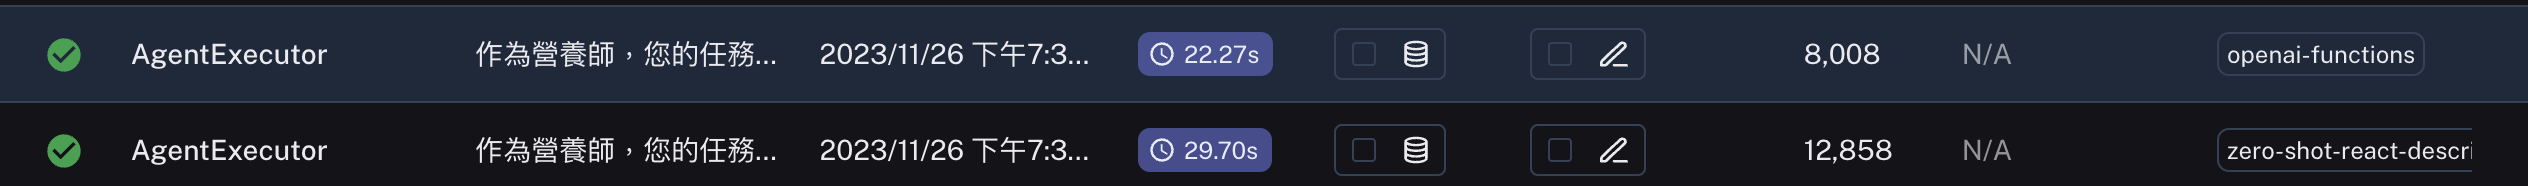

這是 Function Calling 過程:

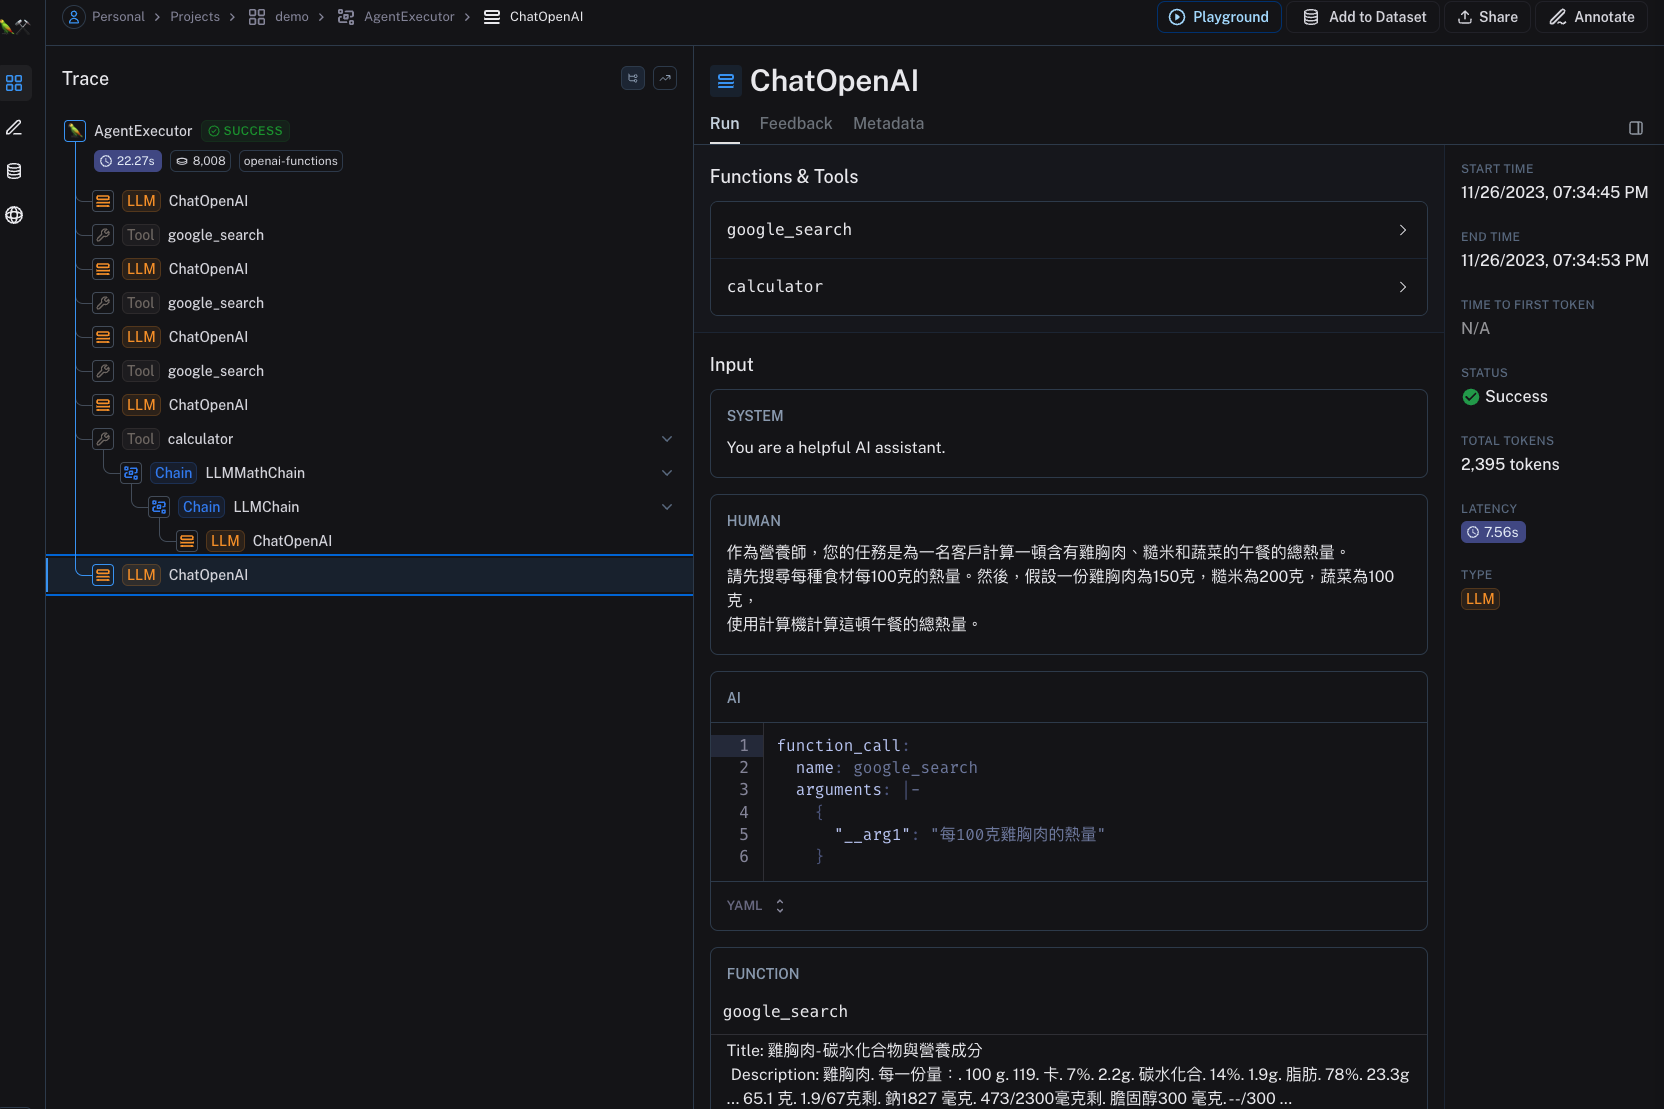